In [1]:
import os
import sys
import onnx
import numpy as np
import pickle as pkl
import onnxruntime as ort
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import csv

sys.path.append("../src/")

from preprocessing_utils import normalize, centroid, to_polar, to_cart, reorient_to_match_training
import metrics
from dataset import IRCADB_Dataset

# Sample Data

Text(0.5, 0.98, 'slice-71.npy')

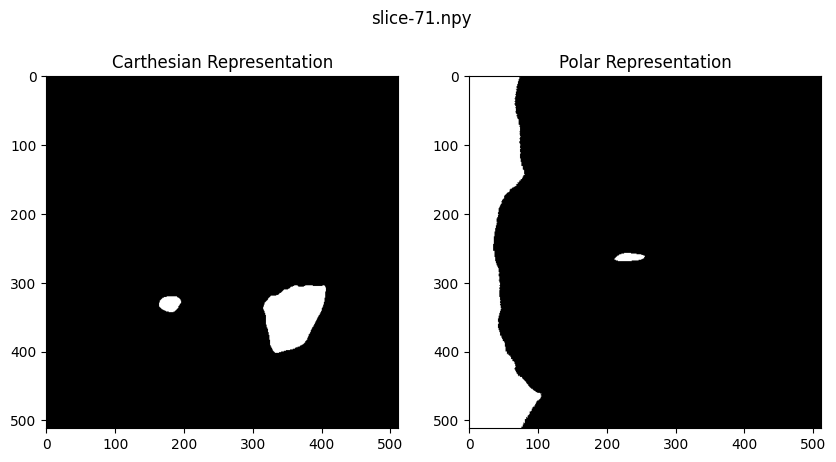

In [20]:
VOLUME_NO = 1
ROOT_SAMPLES_PATH = f"../../../../Downloads/test_dataset/Test_Data_3Dircadb1/Volumes/volume-{VOLUME_NO}/"
ROOT_MASKS_PATH = f"../../../../Downloads/test_dataset/Test_Data_3Dircadb1/LesionMasks/volume-{VOLUME_NO}/"

# Find a slice with marked lesion

for slice_name in os.listdir(ROOT_MASKS_PATH):
    slice_mask = reorient_to_match_training(np.load(os.path.join(ROOT_MASKS_PATH, slice_name)))
    if "71" in slice_name:
        valid_mask_name = slice_name
        valid_mask_data = slice_mask.copy()
        break

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
center = centroid(valid_mask_data)
axs[0].imshow(valid_mask_data, cmap="gray")
axs[0].set_title("Carthesian Representation")
axs[1].imshow(to_polar(valid_mask_data, center), cmap="gray")
axs[1].set_title("Polar Representation")
# axs[2].imshow(to_cart(to_polar(valid_mask_data, center), center), cmap="gray")
fig.suptitle(valid_mask_name)

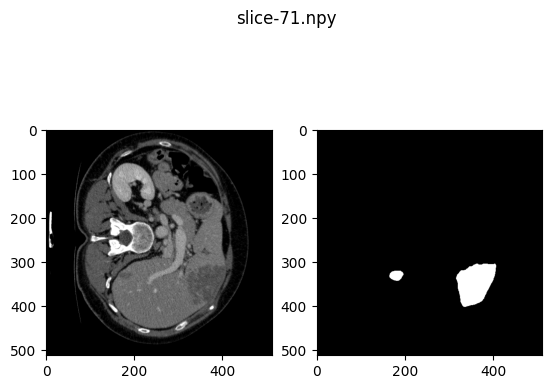

In [21]:
# Plot slice and annotation
valid_sample_slice = reorient_to_match_training(np.load(os.path.join(ROOT_SAMPLES_PATH, valid_mask_name)))
postprocessed_slice = normalize(valid_sample_slice, zero_center=False, unit_variance=False)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(postprocessed_slice, cmap="gray")
axs[1].imshow(valid_mask_data, cmap="gray")

_ = fig.suptitle(valid_mask_name)


# Carthesian Inference Session

In [9]:
EXPERIMENT_PATH = "../experiments_data/set_3/lesion/experiment_7/"
CONFIG_NAME = "experiment_config.pkl"
MODEL_NAME = "best_val_dice.onnx"

with open(os.path.join(EXPERIMENT_PATH, CONFIG_NAME), "rb") as f:
    experiment_config = pkl.load(f)
pprint(experiment_config)

carthesian_model = onnx.load(os.path.join(EXPERIMENT_PATH, MODEL_NAME))
onnx.checker.check_model(carthesian_model)

carthesian_inference_session = ort.InferenceSession(os.path.join(EXPERIMENT_PATH, MODEL_NAME))

{'device': 'cuda',
 'model_config': {'backbone': 'base',
                  'block_type': 'base',
                  'channels': 1,
                  'dilation': [1, 1, 1, 1, 1],
                  'dilation_up': [1, 1, 1, 1, 1],
                  'dropout': 0,
                  'filter_sizes': [20, 40, 80, 160, 320, 640],
                  'filter_sizes_up': [20, 40, 80, 160, 320, 640],
                  'filter_start': 20,
                  'filter_start_up': 20,
                  'init_type': 'he_n',
                  'model': 'classic_unet',
                  'model_name': 'vUnet2D',
                  'se_reduction': 0,
                  'structure': [3, 3, 3, 3, 3],
                  'structure_up': [3, 3, 3, 3, 3],
                  'up_conv_type': [4, 2, 1],
                  'use_auxiliary_inputs': False,
                  'use_batchnorm': True,
                  'use_conv_pool': True,
                  'use_pypool': False},
 'training_config': {'Training_ROI_Vicinity': 4,
       

## Predict

In [23]:
carthesian_input = np.expand_dims(np.expand_dims(postprocessed_slice, 0), 0).astype(np.float32)
# print(carthesian_input.shape)
carthesian_out = carthesian_inference_session.run(None, {"input": carthesian_input})[0]
carthesian_model_prediction = np.argmax(carthesian_out, axis=1)[0]
# print(carthesian_model_prediction.shape)
# print(np.unique(carthesian_model_prediction))

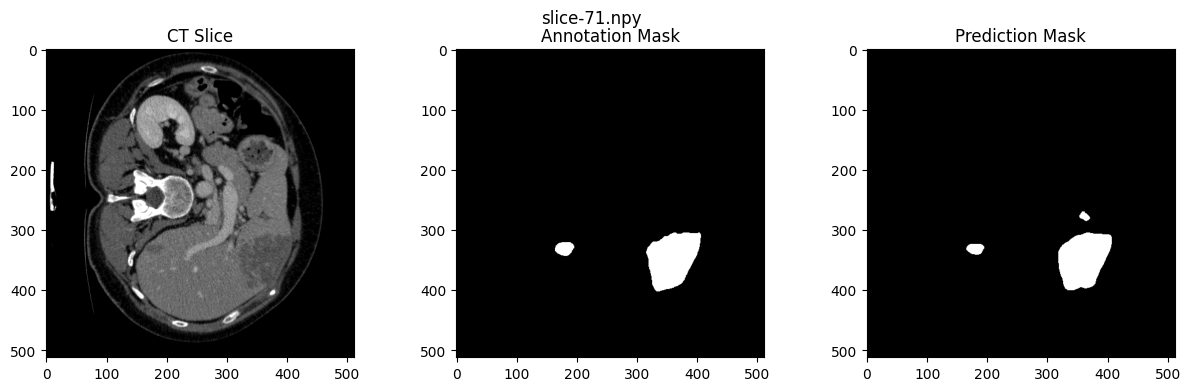

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].imshow(postprocessed_slice, cmap="gray")
axs[0].set_title("CT Slice")
axs[1].imshow(valid_mask_data, cmap="gray")
axs[1].set_title("Annotation Mask")
axs[2].imshow(carthesian_model_prediction, cmap="gray")
axs[2].set_title("Prediction Mask")

_ = fig.suptitle(valid_mask_name)

Text(0.5, 0.98, 'Carthesian prediction - polar representation')

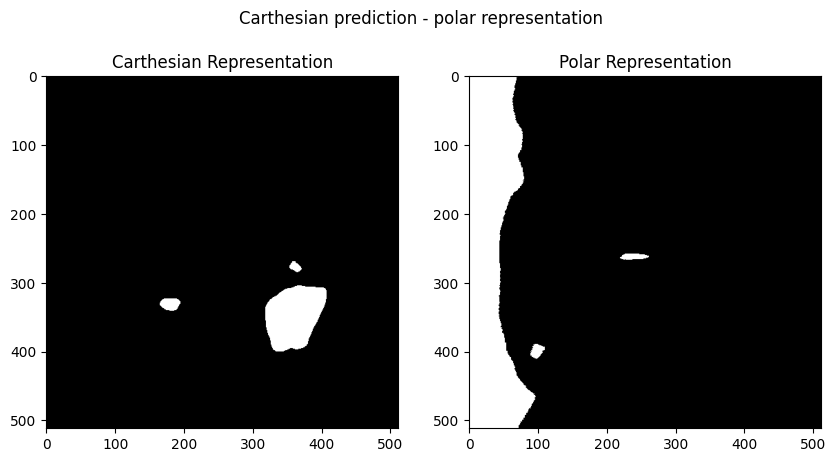

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

center = centroid(carthesian_model_prediction.astype(np.uint8))
axs[0].imshow(carthesian_model_prediction, cmap="gray")
axs[0].set_title("Carthesian Representation")
axs[1].imshow(to_polar(carthesian_model_prediction, center), cmap="gray")
axs[1].set_title("Polar Representation")
plt.suptitle("Carthesian prediction - polar representation")

# Polar Inference Session

In [26]:
EXPERIMENT_PATH = "../experiments_data/set_3/lesion/experiment_6/"

with open(os.path.join(EXPERIMENT_PATH, CONFIG_NAME), "rb") as f:
    experiment_config = pkl.load(f)
pprint(experiment_config)

polar_model = onnx.load(os.path.join(EXPERIMENT_PATH, MODEL_NAME))
onnx.checker.check_model(polar_model)

polar_inference_session = ort.InferenceSession(os.path.join(EXPERIMENT_PATH, MODEL_NAME))

{'device': 'cuda',
 'model_config': {'backbone': 'base',
                  'block_type': 'base',
                  'channels': 1,
                  'dilation': [1, 1, 1, 1, 1],
                  'dilation_up': [1, 1, 1, 1, 1],
                  'dropout': 0,
                  'filter_sizes': [20, 40, 80, 160, 320, 640],
                  'filter_sizes_up': [20, 40, 80, 160, 320, 640],
                  'filter_start': 20,
                  'filter_start_up': 20,
                  'init_type': 'he_n',
                  'model': 'classic_unet',
                  'model_name': 'vUnet2D',
                  'se_reduction': 0,
                  'structure': [3, 3, 3, 3, 3],
                  'structure_up': [3, 3, 3, 3, 3],
                  'up_conv_type': [4, 2, 1],
                  'use_auxiliary_inputs': False,
                  'use_batchnorm': True,
                  'use_conv_pool': True,
                  'use_pypool': False},
 'training_config': {'Training_ROI_Vicinity': 4,
       

## Predict

In [27]:
def predict_carthesian_polar(scan_slice, carthesian_inf_session, polar_inf_session):
    # Compute carthesian model prediction
    carthesian_input = np.expand_dims(np.expand_dims(scan_slice, 0), 0).astype(np.float32)
    carthesian_out = carthesian_inf_session.run(None, {"input": carthesian_input})[0]
    carthesian_model_prediction = np.argmax(carthesian_out, axis=1)[0]

    # Extract center from carthesian prediction
    center = centroid(carthesian_model_prediction.astype(np.uint8))
    print(f"Center coordinates: {center}")

    # Convert input scan slice to polar coordinate system
    polar_input = np.expand_dims(np.expand_dims(to_polar(scan_slice, center), 0), 0).astype(np.float32)

    # Compute polar model prediction
    polar_out = polar_inf_session.run(None, {"input": polar_input})[0]
    polar_model_prediction = np.argmax(polar_out, axis=1)[0]

    return carthesian_model_prediction, to_cart(polar_model_prediction, center), polar_model_prediction, center


In [17]:
def predict_mask_polar(scan_slice, scan_annotation, polar_inf_session):
    # Extract center from scan mask
    center = centroid(scan_annotation.astype(np.uint8))
    print(f"Center coordinates: {center}")

    # Convert input scan slice to polar coordinate system
    polar_input = np.expand_dims(np.expand_dims(to_polar(scan_slice, center), 0), 0).astype(np.float32)

    # Compute polar model prediction
    polar_out = polar_inf_session.run(None, {"input": polar_input})[0]
    polar_model_prediction = np.argmax(polar_out, axis=1)[0]

    return polar_model_prediction, to_cart(polar_model_prediction, center), center

Center coordinates: (348, 346)


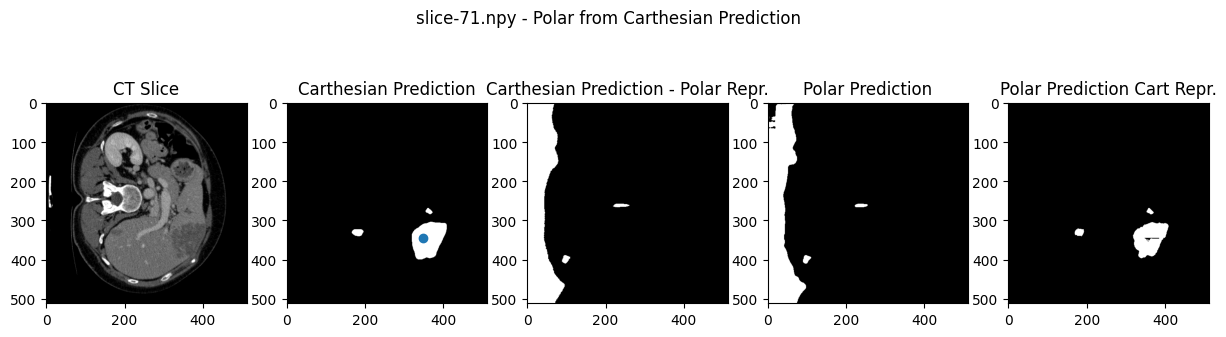

In [28]:
carthesian_prediction, polar_prediction_cart_representation, polar_prediction, carthesian_prediction_center = predict_carthesian_polar(
    postprocessed_slice, carthesian_inference_session, polar_inference_session
    )

fig, axs = plt.subplots(1, 5, figsize=(15, 4))
axs[0].imshow(postprocessed_slice, cmap="gray")
axs[0].set_title("CT Slice")
axs[1].imshow(carthesian_prediction, cmap="gray")
axs[1].scatter(*carthesian_prediction_center)
axs[1].set_title("Carthesian Prediction")
axs[2].imshow(to_polar(carthesian_prediction, carthesian_prediction_center), cmap="gray")
axs[2].set_title("Carthesian Prediction - Polar Repr.")
axs[3].imshow(polar_prediction, cmap="gray")
axs[3].set_title("Polar Prediction")
axs[4].imshow(polar_prediction_cart_representation, cmap="gray")
axs[4].set_title("Polar Prediction Cart Repr.")

_ = fig.suptitle(valid_mask_name + " - Polar from Carthesian Prediction")

Center coordinates: (343, 347)


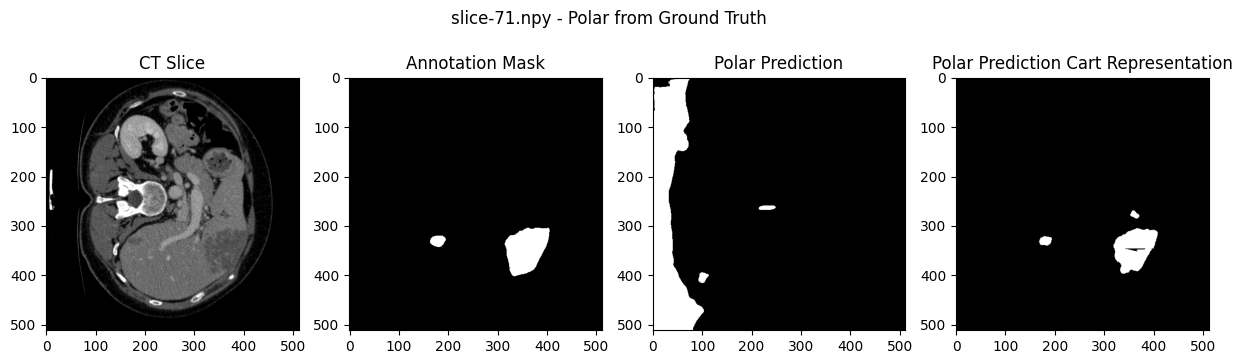

In [29]:
polar_prediction, polar_prediction_cart_representation, center = predict_mask_polar(
    postprocessed_slice, valid_mask_data, polar_inference_session,
    )

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
axs[0].imshow(postprocessed_slice, cmap="gray")
axs[0].set_title("CT Slice")
axs[1].imshow(valid_mask_data, cmap="gray")
axs[1].set_title("Annotation Mask")
axs[2].imshow(polar_prediction, cmap="gray")
axs[2].set_title("Polar Prediction")
axs[3].imshow(polar_prediction_cart_representation, cmap="gray")
axs[3].set_title("Polar Prediction Cart Representation")

_ = fig.suptitle(valid_mask_name + " - Polar from Ground Truth")

# Prediction Comparison: Carthesian vs Polar

In [13]:
def plot_mask_vs_prediction(scan_slice, mask, prediction, title):
    multi_channel_slice = np.stack(3 * [scan_slice], axis=2)

    # true positive predictions = green
    intersection = mask * prediction
    multi_channel_slice[np.nonzero(intersection)] = (0.0, 1.0, 0.0)
    
    # false positive predictions = red
    multi_channel_slice[np.nonzero((mask == 0) * (prediction == 1))] = (1.0, 0.0, 0.0)

    # false negative prediction = blue
    multi_channel_slice[np.nonzero((mask == 1) * (prediction == 0))] = (0.0, 0.0, 1.0)

    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    
    axs[0].imshow(scan_slice, cmap="gray")
    axs[1].imshow(multi_channel_slice)
    plt.suptitle(title)
    plt.legend(handles=[
        mpatches.Patch(color="lawngreen", label="True Positives"),
        mpatches.Patch(color="red", label="False Positives"),
        mpatches.Patch(color="blue", label="False Negatives")
        ])
    

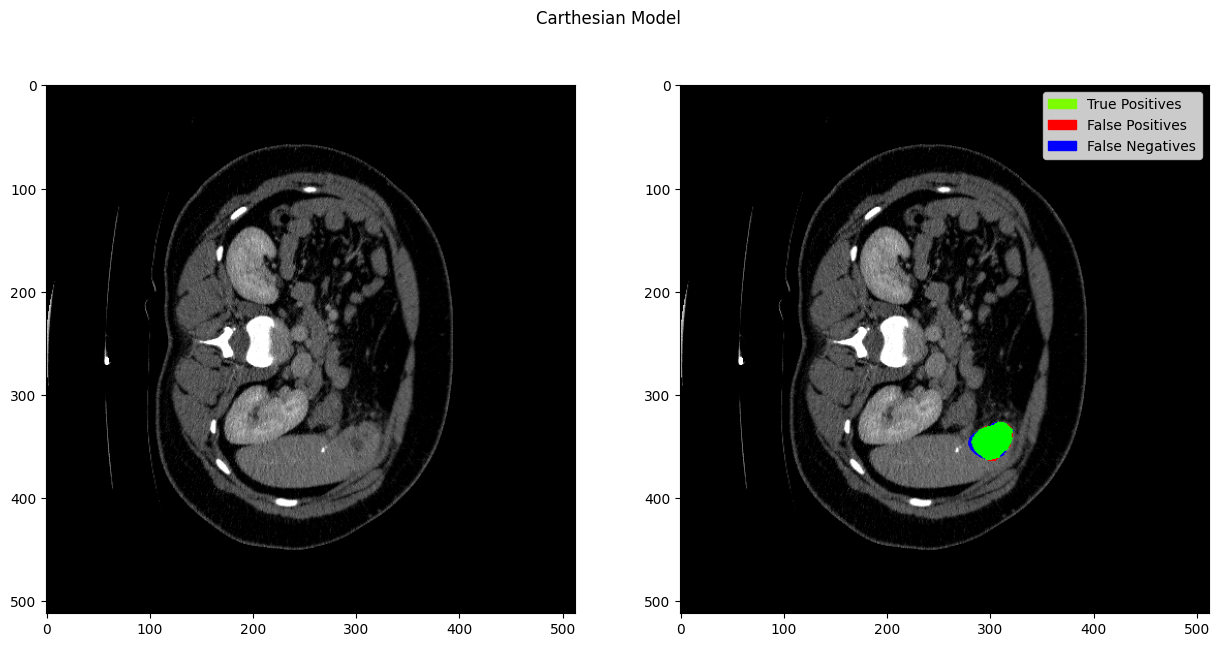

In [14]:
plot_mask_vs_prediction(postprocessed_slice, valid_mask_data, carthesian_prediction, "Carthesian Model")

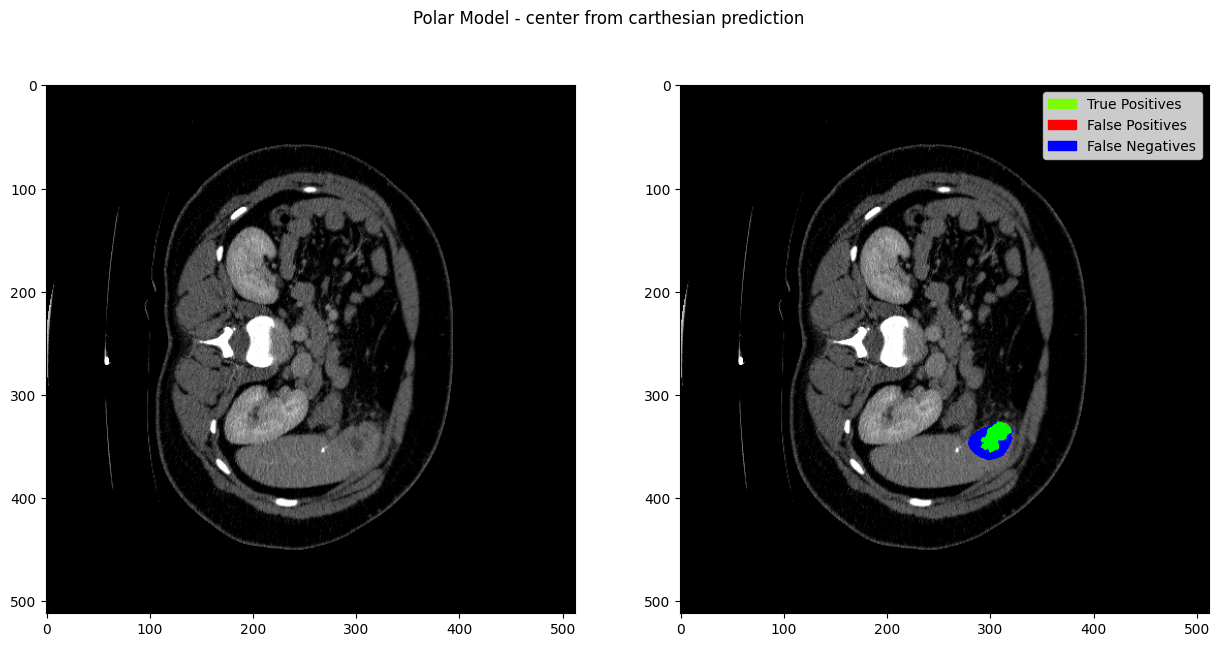

In [15]:
plot_mask_vs_prediction(postprocessed_slice, valid_mask_data, polar_prediction_cart_representation, "Polar Model - center from carthesian prediction")

# Evaluate carthesian model on test dataset

In [4]:
test_dataset = IRCADB_Dataset(root_path="../../../../Downloads/test_dataset/Test_Data_3Dircadb1/")
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1,
    num_workers=0,
    shuffle=False
)

In [5]:
def onnx_inference(inference_session, input_slice):
    model_probabilities = inference_session.run(None, {"input": input_slice})[0]
    model_prediction = np.argmax(model_probabilities, axis=1)
    return model_prediction, model_probabilities
        

In [6]:
def polar_inference(carthesian_inf_session, polar_inf_session, scan_slice):
    # Compute carthesian model prediction
    carthesian_model_prediction, _ = onnx_inference(carthesian_inf_session, scan_slice)
    
    # Extract center from carthesian prediction
    center = centroid(carthesian_model_prediction[0].astype(np.uint8))

    # Convert input scan slice to polar coordinate system
    polar_scan_slice = np.expand_dims(np.expand_dims(to_polar(scan_slice[0,0], center), 0), 0).astype(np.float32)

    # Compute polar model prediction
    polar_model_prediction, _ = onnx_inference(polar_inf_session, polar_scan_slice)
    
    return polar_model_prediction

In [51]:
iter_preds_collect, iter_target_collect, iter_probs_collect = [], [], []

GENERATED_MASKS_ROOT_PATH = "/home/tvlad/Downloads/test_dataset/Generated_Masks/"
results_log = open(os.path.join(GENERATED_MASKS_ROOT_PATH, "test_metrics.csv"), "w", encoding="UTF-8")
test_metrics_ledger = csv.writer(results_log)
test_metrics_ledger.writerow(["volume", "test_dice", "test_iou", "test_precision", "test_accuracy", "test_recall", "test_specificity", "test_auc_score"])

for item_idx , test_item in enumerate(test_dataloader):
    if test_item["volume"][0] == "volume-18":
        input_image = test_item["input_image"].numpy()
        input_mask = test_item["input_mask"].numpy()
        
        masks_save_dir_path = os.path.join(GENERATED_MASKS_ROOT_PATH, test_item["volume"][0])
        if not os.path.exists(masks_save_dir_path):
            os.mkdir(masks_save_dir_path)

        predicted_mask, predicted_probabilities = onnx_inference(carthesian_inference_session, input_image)

        # print(input_image.shape)
        # print(input_mask.shape)
        # print(predicted_mask.shape)
        # print(predicted_probabilities.shape)
        # break
        # if test_item["slice_path"][0].split('/')[-1] == "slice-34.npy":
        #     fig, axs = plt.subplots(1, 3, figsize=(20, 20))
        #     axs[0].imshow(input_image[0, 0])
        #     axs[1].imshow(input_mask[0, 0])
        #     axs[2].imshow(predicted_mask[0])
        #     break

        np.save(os.path.join(masks_save_dir_path, test_item["slice_path"][0].split("/")[-1]), predicted_mask[0, 0])
        
        iter_target_collect.append(input_mask.astype(np.uint8))
        iter_preds_collect.append(predicted_mask.astype(np.uint8))
        iter_probs_collect.append(predicted_probabilities)

        if test_item["volume_change"] == True or item_idx == len(test_dataloader) - 1:  
            print(f"Compute metrics for {test_item['volume'][0]} at {test_item['slice_path'][0].split('/')[-1]}")

            probabilities_predictions = np.vstack(iter_probs_collect)
            class_predictions = np.vstack(iter_preds_collect)
            labels = np.vstack(iter_target_collect)

            iter_preds_collect, iter_target_collect, iter_probs_collect = [], [], []

            confusion_matrix = metrics.ConfusionMatrix(class_predictions, labels)
            false_positives, true_positives = confusion_matrix[0 ,1], confusion_matrix[1, 1]
            false_negatives, true_negatives = confusion_matrix[1 ,0], confusion_matrix[0, 0]

            mini_dice = metrics.Dice2(true_positives, false_positives, false_negatives)
            mini_iou = metrics.IoU2(true_positives, false_positives, false_negatives)
            mini_accuracy = metrics.Accuracy(true_positives, true_negatives, false_positives, false_negatives)
            mini_precision = metrics.Precision(true_positives, false_positives)
            mini_recall = metrics.Recall(true_positives, false_negatives)
            mini_specificity = metrics.Specificity(true_negatives, false_positives)
            mini_auc_score = metrics.AuC(labels, probabilities_predictions)

            test_metrics_ledger.writerow([test_item['volume'][0], mini_dice, mini_iou, mini_precision, mini_accuracy, mini_recall, mini_specificity, mini_auc_score])

results_log.close()

Compute metrics for volume-18 at slice-73.npy


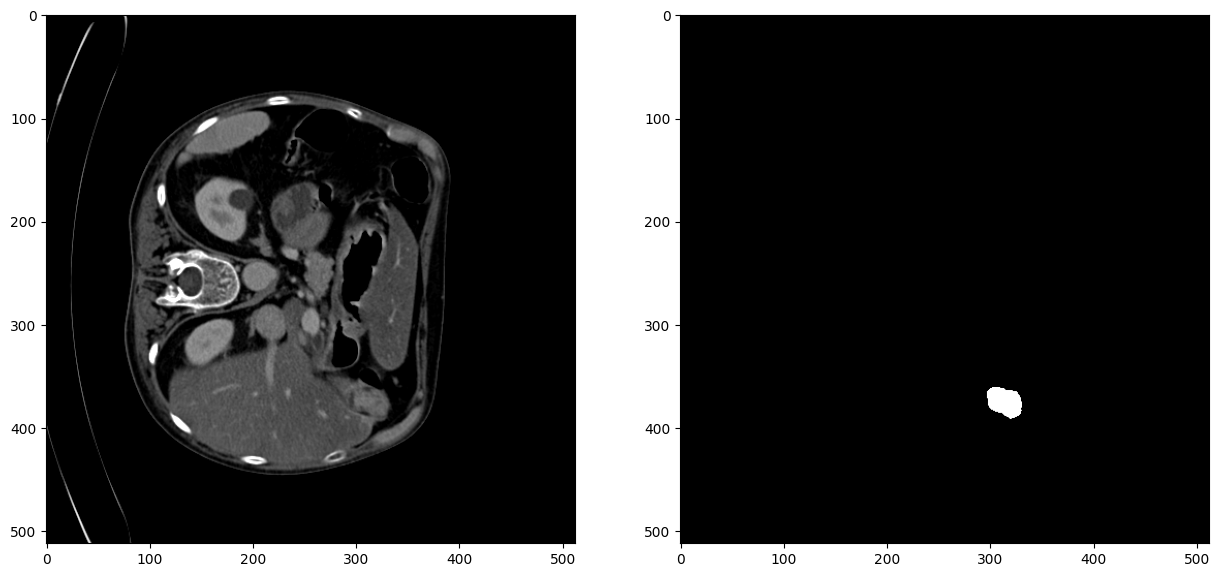

In [12]:
mask = np.load("/home/tvlad/Downloads/test_dataset/Test_Data_3Dircadb1/LesionMasks/volume-18/slice-34.npy")
slice = np.load("/home/tvlad/Downloads/test_dataset/Test_Data_3Dircadb1/Volumes/volume-18/slice-34.npy")

mask = reorient_to_match_training(mask)
slice = reorient_to_match_training(normalize(slice, zero_center=False, unit_variance=False))

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(slice, cmap="gray")
axs[1].imshow(mask, cmap="gray")

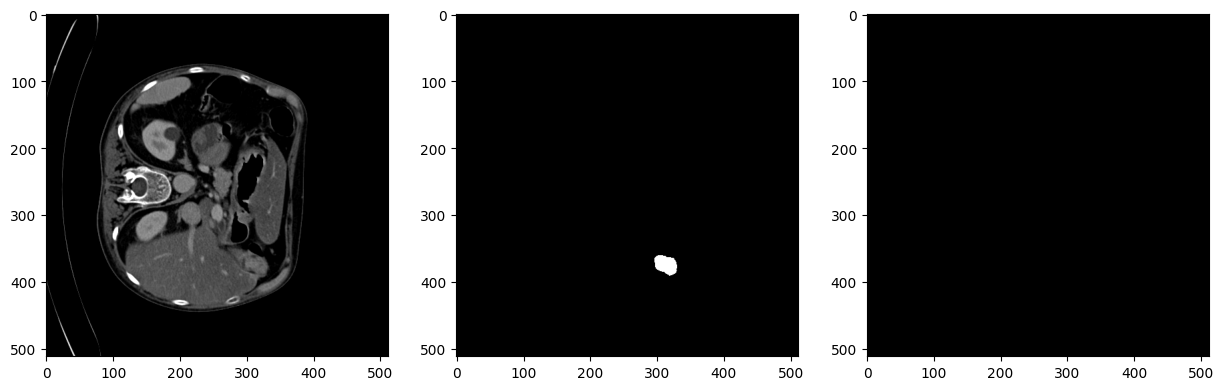

In [11]:
carthesian_input = np.expand_dims(np.expand_dims(slice, 0), 0).astype(np.float32)
carthesian_out = carthesian_inference_session.run(None, {"input": carthesian_input})[0]
carthesian_model_prediction = np.argmax(carthesian_out, axis=1)[0]

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(slice, cmap="gray")
axs[1].imshow(mask, cmap="gray")
axs[2].imshow(carthesian_model_prediction, cmap="gray")